In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
import cv2
import random
import matplotlib.pyplot as plt
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [5]:
# Data Loading and Preprocessing
data_path = '/kaggle/input/dermnet/train'
train_data = []
val_data = []

for folder in os.listdir(data_path):
    folder_path = os.path.join(data_path, folder)
    files = os.listdir(folder_path)
    num_train = int(0.8 * len(files))
    files_train = random.sample(files, num_train)
    files_val = list(set(files) - set(files_train))
    
    for file in files_train:
        file_path = os.path.join(folder_path, file)
        img = cv2.imread(file_path)
        img = cv2.resize(img, (224, 224))
        train_data.append((img, folder))
        
    for file in files_val:
        file_path = os.path.join(folder_path, file)
        img = cv2.imread(file_path)
        img = cv2.resize(img, (224, 224))
        val_data.append((img, folder))

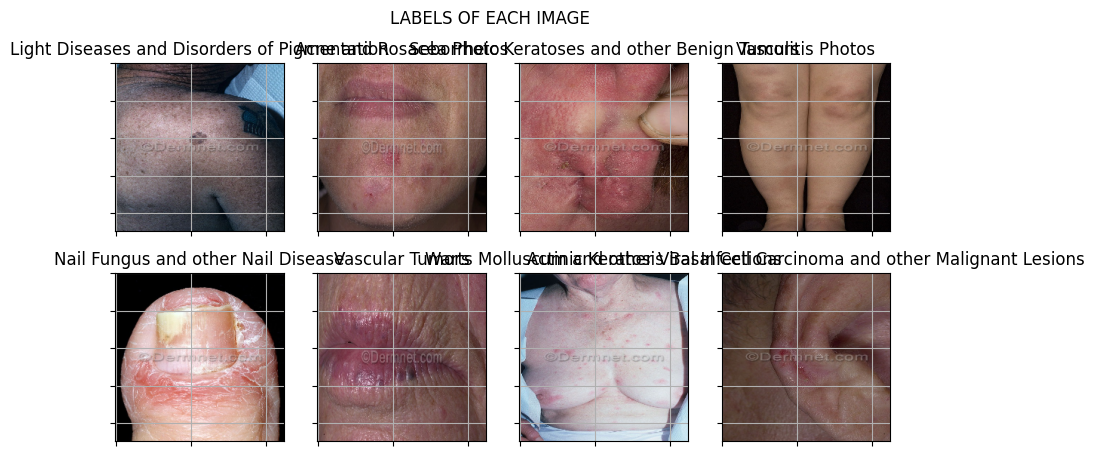

In [6]:
# Visualize Some Training Images
fig, axes = plt.subplots(2, 4, figsize=(10, 5))
plt.suptitle('LABELS OF EACH IMAGE')

for (img, label), ax in zip(random.sample(train_data, 8), axes.flatten()):
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    ax.grid(True)
    ax.set_title(label)
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

plt.show()

In [7]:
# Prepare Data for Training
X_train, y_train = zip(*train_data)
X_val, y_val = zip(*val_data)

X_train = preprocess_input(np.array(X_train))
X_val = preprocess_input(np.array(X_val))

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_val_encoded = le.transform(y_val)

num_classes = len(le.classes_)
y_train_one_hot = to_categorical(y_train_encoded, num_classes)
y_val_one_hot = to_categorical(y_val_encoded, num_classes)


In [8]:
# Define Function to Create Model
def create_model():
    base_model = ResNet101(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(512, activation='relu')(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [9]:
# Train the Model
model = create_model()
EPOCHS = 20
BATCH_SIZE =32 
custom_early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=10, 
    min_delta=0.001, 
    mode='min'
)

history = model.fit(X_train, y_train_one_hot, 
                    validation_data=(X_val, y_val_one_hot),
                    epochs=EPOCHS, 
                    batch_size=BATCH_SIZE, 
                    callbacks=[custom_early_stopping])

171446536/171446536 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Epoch 1/20


I0000 00:00:1725438595.966540     107 service.cc:145] XLA service 0x7951cc003f60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1725438595.967295     107 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1725438639.295525     107 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_50', 224 bytes spill stores, 224 bytes spill loads

I0000 00:00:1725438639.372284     107 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


389/389 ━━━━━━━━━━━━━━━━━━━━ 265s 413ms/step - accuracy: 0.1403 - loss: 2.9944 - val_accuracy: 0.1584 - val_loss: 2.9843
Epoch 2/20
389/389 ━━━━━━━━━━━━━━━━━━━━ 108s 276ms/step - accuracy: 0.1931 - loss: 2.7185 - val_accuracy: 0.1484 - val_loss: 3.0110
Epoch 3/20
389/389 ━━━━━━━━━━━━━━━━━━━━ 107s 276ms/step - accuracy: 0.2373 - loss: 2.5654 - val_accuracy: 0.2276 - val_loss: 2.6062
Epoch 4/20
389/389 ━━━━━━━━━━━━━━━━━━━━ 107s 276ms/step - accuracy: 0.2714 - loss: 2.4397 - val_accuracy: 0.2264 - val_loss: 2.6579
Epoch 5/20
389/389 ━━━━━━━━━━━━━━━━━━━━ 107s 276ms/step - accuracy: 0.3153 - loss: 2.2791 - val_accuracy: 0.2421 - val_loss: 2.6160
Epoch 6/20
389/389 ━━━━━━━━━━━━━━━━━━━━ 107s 276ms/step - accuracy: 0.3378 - loss: 2.1649 - val_accuracy: 0.2581 - val_loss: 2.5612
Epoch 7/20
389/389 ━━━━━━━━━━━━━━━━━━━━ 107s 276ms/step - accuracy: 0.3732 - loss: 2.0228 - val_accuracy: 0.2937 - val_loss: 2.3335
Epoch 8/20
389/389 ━━━━━━━━━━━━━━━━━━━━ 107s 276ms/step - accuracy: 0.4315 - loss: 1.83

In [10]:
# Save the model
model.save('/kaggle/working/my_resnet101_model.h5')

In [ ]:
# Confusion Matrix and Evaluation
test_path = '/kaggle/input/dermnet/test'
real_label = []
predicted_class = []

for folder in os.listdir(test_path):
    folder_path = os.path.join(test_path, folder)
    for file in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file)
        img = cv2.imread(file_path)
        img = cv2.resize(img, (224, 224))
        img = preprocess_input(np.array([img]))  # Add an extra dimension for batching

        prediction = model.predict(img)
        real_label.append(folder)
        predicted_class_index = np.argmax(prediction)
        predicted_class.append(le.classes_[predicted_class_index])

conf_matrix = confusion_matrix(real_label, predicted_class)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━

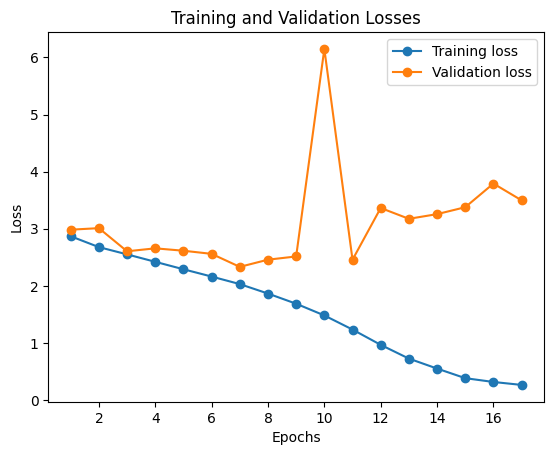

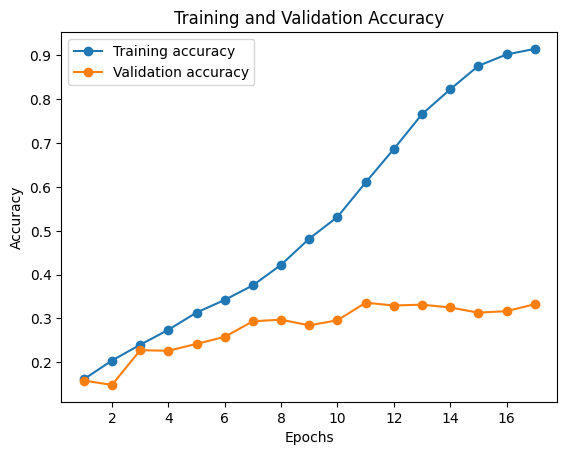

In [13]:
# Plot Training and Validation Loss and Accuracy
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(1, len(train_loss) + 1)

plt.figure()
plt.plot(epochs, train_loss, label='Training loss', marker='o')
plt.plot(epochs, val_loss, label='Validation loss', marker='o')
plt.title('Training and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure()
plt.plot(epochs, train_acc, label='Training accuracy', marker='o')
plt.plot(epochs, val_acc, label='Validation accuracy', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [14]:
# Extract history
history_dict = history.history

# Convert history to DataFrame
history_df = pd.DataFrame(history_dict)

# Display the DataFrame
print(history_df)

# Print the table
print(history_df)

# Save it to a CSV file
history_df.to_csv('training_history.csv', index=False)

    accuracy      loss  val_accuracy  val_loss
0   0.161441  2.869313      0.158384  2.984309
1   0.204132  2.679357      0.148445  3.010999
2   0.240071  2.552290      0.227637  2.606190
3   0.274240  2.421987      0.226355  2.657879
4   0.313555  2.291790      0.242065  2.616039
5   0.342338  2.164022      0.258096  2.561240
6   0.375623  2.032191      0.293684  2.333536
7   0.422415  1.866546      0.297211  2.459394
8   0.482151  1.688694      0.284386  2.515866
9   0.531597  1.483621      0.295928  6.147620
10  0.610227  1.236459      0.336005  2.458555
11  0.686525  0.968946      0.329593  3.364127
12  0.765959  0.728323      0.331517  3.174551
13  0.822640  0.553909      0.325104  3.256325
14  0.876266  0.385890      0.313241  3.377573
15  0.902235  0.319238      0.316768  3.791321
16  0.914858  0.267663      0.332478  3.497907
    accuracy      loss  val_accuracy  val_loss
0   0.161441  2.869313      0.158384  2.984309
1   0.204132  2.679357      0.148445  3.010999
2   0.240071 